# Transcription factor binding analysis with convolutional networks

In this tutorial, we will walk through a simple tensorflow example of how to build, train, and evaluate a convolutional neural network for a common supervised classification learning task of predicting whether or not a TF binds to a given sequence. 

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

/Users/eddy_lab/tensorflow/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# load CTCF dataset

CTCF conservative narrow peaks were downloaded from the ENCODE database:
https://www.encodeproject.org/experiments/ENCSR000BIE/

!wget https://www.encodeproject.org/files/ENCFF252PLM/@@download/ENCFF252PLM.bed.gz

The peaks were processed with a script (process_chip.py), whose steps include:
    1. enforce a constant window about each peak (window size = 100 nts)
    2. employ bedtools to extract sequences from GRC38 reference genome
    3. filter sequences which contain `N' characters
    4. convert sequences into a one-hot representation
    5. generate background sequences by performing a dinucleotide shuffle using meme
    6. combine and shuffles positive and negative sequences
    7. create a label vector with either a one for sequences that has a ChIP-seq peak and a zero for di-nuc shuffled sequences
    8. split the dataset into a training set, validation set, and test set
    9. save dataset to a hdf5 file

In [2]:
# path to dataset 
data_file_path = '../data/CTCF_100.h5'

# load dataset
dataset = h5py.File(data_file_path, 'r')
X_train = np.array(dataset['X_train']).astype(np.float32)
Y_train = np.array(dataset['Y_train']).astype(np.float32)
X_valid = np.array(dataset['X_valid']).astype(np.float32)
Y_valid = np.array(dataset['Y_valid']).astype(np.float32)
X_test = np.array(dataset['X_test']).astype(np.float32)
Y_test = np.array(dataset['Y_test']).astype(np.float32)

# add another dimension to make it a 4D tensor and 
# transpose dimensions so that it matches convolutional layer inputs:
#                  (batch size, sequence length, 1, nucleotide channels)
#    Note: adding an additional dimension is required because we will be using 2D convolution functions,
#          because tensorflow doesn't support a lot of functions for 1D sequences.  Effectively, its like
#          treating second dimension as an image with one pixel in one axis.
X_train = np.expand_dims(X_train, axis=3).transpose([0, 2, 3, 1])
X_test = np.expand_dims(X_test, axis=3).transpose([0, 2, 3, 1])
X_valid = np.expand_dims(X_valid, axis=3).transpose([0, 2, 3, 1])

# get shapes of data
num_data, seq_length, _, dims = X_train.shape

# build our convolutional neural network model 

Our model will be similar to DeepBind: one convolutional layer, one fully-connected hidden layer, followed by an output layer.  

### Reset graphs 

This is necessary if you accidentally build multiple graphs, then the other graphs will also save as will the other graph's parameters. 

In [3]:
tf.reset_default_graph()

### create placeholders  

placeholders allow us to input data into the graph. 

In [4]:
# create a placeholder for the data
inputs = tf.placeholder(tf.float32, shape=[None, seq_length, 1, dims], name='inputs')

# create placeholder for labels 
targets = tf.placeholder(tf.float32, shape=[None, 1], name='targets')

 A shape of None means that it is variable.  This is useful so that we can change the batch size to whatever we want during run time.
 
 Now, we are going to be instantiating tensorflow variables.  To do so, we need to initialize them.  A standard initialization used for neural networks is He-inits and Glorot-inits.  Here, we will use he inits.  Let's define a function for He-inits for the parameters and constant-inits for the bias terms.

In [3]:
# functions for initializations also known as inits
def he_init(shape, fan_in):
    """He inits are designed for neural networks that employ ReLU activations."""
    # fan_in is the number of neurons going into the layer
    stddev = np.sqrt(2.6/fan_in)
    return tf.truncated_normal(shape=shape, mean=0.0, stddev=stddev, dtype=tf.float32)

def const_init(shape, value=0.0):
    """constant inits are useful for bias terms"""
    return tf.constant(shape=shape, value=value, dtype=tf.float32)

#### Convolutional layer

In [6]:
# build the first convolutional layer
num_filters = 16
filter_size = 19
strides = 1

# shape = [1st dim size, 2nd dim size, # of incoming channels, # of outgoing channels]
shape = [filter_size, 1, dims, num_filters]
W_inits = he_init(shape=shape, fan_in=dims*seq_length)
W1 = tf.Variable(W_inits, name='W1', trainable=True) 

# perform convolution
conv_1 = tf.nn.conv2d(inputs, 
                      filter=W1,                   # initialized filter variable
                      strides=[1, strides, 1, 1],  # strides performs the step size of the convolution 
                      padding='SAME')              # padding is either 'SAME' or 'VALID'

Now we can add a bias term for each filter and perform a non-linear activation with a rectified linear unit.

In [7]:
# initialize bias
b_inits = const_init(shape=[num_filters], value=0.01)  
b1 = tf.Variable(b_inits, name='b1')   # trainable=True is default 

# add bias term
conv_1_bias = tf.nn.bias_add(conv_1, b1)

# perform non-linear activation
conv_1_active = tf.nn.relu(conv_1_bias)

#### Max-pool layer

In [8]:
# downsample data with max-pooling
pool_size = 25
conv_1_pool = tf.nn.max_pool(conv_1, 
                             ksize=(1,pool_size,1,1),     # pool size
                             strides=(1,pool_size,1,1),   # strides sets the step size of the windows
                             padding='SAME')              # padding is either 'SAME' or 'VALID'

Fully-connected (dense) layers can be accomplished with a single matrix multiplication.  To do this, we need to reshape the 4D tensor into a 2D tensor.  

In [9]:
# get number of input neurons
num_incoming = np.prod(conv_1_pool.get_shape()[1:]).value

# reshape convolutional outputs to a vector
conv_1_flat = tf.reshape(conv_1_pool, shape=(-1,num_incoming))

#### fully-connected hidden layer

In [10]:
# build a fully-connected layer (also known as a dense layer)
num_units = 32
W2 = tf.Variable(he_init(shape=[num_incoming, num_units], fan_in=num_incoming), name='W2')
dense_2 = tf.matmul(conv_1_flat, W2)

# add bias term
b2 = tf.Variable(const_init(shape=[num_units], value=0.01), name='b2')
dense_2_bias = tf.nn.bias_add(dense_2, b2)

# perform activation
dense_2_active = tf.nn.relu(dense_2_bias)

#### fully-connected output layer

In [12]:
# build a fully-connected layer (also known as a dense layer)
W3 = tf.Variable(he_init(shape=[num_units, 1], fan_in=num_units), name='W3')
dense_3 = tf.matmul(dense_2_active, W3)

# add bias term
b3 = tf.Variable(const_init(shape=[1], value=0.01), name='b3')
dense_3_bias = tf.nn.bias_add(dense_3, b3)

# make binary predictions
predictions = tf.nn.sigmoid(dense_3_bias)

# build loss function

In [13]:
# calculate binary cross-entropy loss function
eps = 1e-10
binary_cross_entropy = targets*tf.log(predictions + eps) + (1 - targets)*tf.log(1 - predictions + eps)

# let's calculate the average across classes, i.e. tf.reduce_sum, which is not necessary for this dataset (1 class)
log_likelihood = tf.reduce_sum(binary_cross_entropy, axis=1)

# let's calculate the mean negative log-likelihood within a mini-batch
loss_function = tf.reduce_mean(-log_likelihood)

# build optimizer

In [14]:
# get a list of all trainable variables
trainable_vars = tf.trainable_variables()

# setup optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.0003, 
                                   beta1=0.9, 
                                   beta2=0.999)

# setup an op to update the parameters --> calculates gradients and update parameters
update_vars = optimizer.minimize(loss_function, var_list=trainable_vars)

# create a session

In [15]:
sess = tf.Session()

## Initialize all variables

In [16]:
sess.run(tf.global_variables_initializer())

# train the neural network

We want to train our CNN model with mini-batch stochastic gradient descent.  So, we need a way to generate mini-batches of data. An effective strategy for training is to shuffle the dataset between each epoch. So, let's define a function to generate shuffled mini-batches. 

In [17]:
def batch_generator(X, y, batch_size=128, shuffle=True):
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype(np.float32), y[excerpt].astype(np.float32)

In [18]:
# training parameters
num_epochs = 10        # maximum number of epochs
batch_size = 100         # mini-batch size for a parameter update
num_train_batches = X_train.shape[0] // batch_size

# training loop
for epoch in range(num_epochs):

    # make a batch ganerator for the training data
    train_batches = batch_generator(X_train, Y_train, batch_size, shuffle=True)

    # loop over training batches
    train_loss = 0
    for index in range(num_train_batches):
        
        # get a new mini-batch
        x_batch, y_batch = next(train_batches)
        
        # update over a mini-batch
        loss, _ = sess.run([loss_function, update_vars], 
                           feed_dict={inputs: x_batch, targets: y_batch})
        
        # calculate running sum of loss
        train_loss += loss
        
    # calculate loss and predictions on validation set
    valid_loss, valid_predict = sess.run([loss_function, predictions], 
                                         feed_dict={inputs: X_valid, targets: Y_valid})

    # calculate performance metrics
    fpr, tpr, thresholds = roc_curve(Y_valid[:,0], valid_predict[:,0])
    score = auc(fpr, tpr)

    # print progress
    print("Epoch {} of {}".format(epoch+1, num_epochs))
    print("  training loss:\t\t{:.6f}".format(train_loss/num_train_batches))
    print("  validation loss:\t\t{:.6f}".format(valid_loss))
    print("  validation AU-ROC:\t\t{:.6f}".format(score))

Epoch 1 of 10
  training loss:		0.600256
  validation loss:		0.460961
  validation AU-ROC:		0.874947
Epoch 2 of 10
  training loss:		0.397810
  validation loss:		0.373374
  validation AU-ROC:		0.918676
Epoch 3 of 10
  training loss:		0.343605
  validation loss:		0.341891
  validation AU-ROC:		0.929896
Epoch 4 of 10
  training loss:		0.320468
  validation loss:		0.319317
  validation AU-ROC:		0.937515
Epoch 5 of 10
  training loss:		0.301584
  validation loss:		0.304167
  validation AU-ROC:		0.943135
Epoch 6 of 10
  training loss:		0.287546
  validation loss:		0.295668
  validation AU-ROC:		0.947200
Epoch 7 of 10
  training loss:		0.275340
  validation loss:		0.282530
  validation AU-ROC:		0.950740
Epoch 8 of 10
  training loss:		0.265386
  validation loss:		0.275941
  validation AU-ROC:		0.952965
Epoch 9 of 10
  training loss:		0.257211
  validation loss:		0.284340
  validation AU-ROC:		0.955038
Epoch 10 of 10
  training loss:		0.250348
  validation loss:		0.264061
  validation AU-ROC:

In [19]:
sess.close()

One major drawback to the way we were training previously is that we have to determine an arbitrary number of epochs to train, at which the nerual network can start to overfit, leading to a poorer performance on the validation dataset.  One way around this is to save the model parameters after each epoch and label it with the validation loss, so that we know which set of paramters performs the best.  Another strategy is to only save the parameters when the performance on the validation set is improved, i.e. lower loss value.  We can also stop training earlier when the validation performance doesn't improve for a set number of epochs, known as patience.  


# Train neural network with early stopping  -- saving parameters along the way

Also, the previous model was just a toy model.  Let's build the same model but also include dropout and L2-regularization to improve performance.  

In [18]:
# reset graphs --> this is necessary if you accidentally build multiple graphs, 
#                  then the other graphs will also save as will the other graph's parameters. 
tf.reset_default_graph()
tf.set_random_seed(247)

# create a placeholder for the data
inputs = tf.placeholder(tf.float32, shape=[None, seq_length, 1, dims], name='inputs')

# build the first convolutional layer
num_filters = 16
filter_size = 19
strides = 1
W1 = tf.Variable(he_init(shape=[filter_size, 1, dims, num_filters], fan_in=dims*seq_length), name='W1')
b1 = tf.Variable(const_init(shape=[num_filters], value=0.01), name='b1')
conv_1 = tf.nn.conv2d(inputs, 
                      filter=W1, 
                      strides=[1, strides, 1, 1], 
                      padding='SAME')

# add bias term
conv_1_bias = tf.nn.bias_add(conv_1, b1)

# perform activation
conv_1_active = tf.nn.relu(conv_1_bias)

# downsample data with max-pooling
pool_size = 25
conv_1_pool = tf.nn.max_pool(conv_1, 
                             ksize=(1,pool_size,1,1), 
                             strides=(1,pool_size,1,1), 
                             padding='SAME')

# add dropout -- note that keep prob is a placeholder.  
#This allows us to set different levels of dropout during training and testing
keep_prob_conv = tf.placeholder(tf.float32, name='keep_prob_conv')
conv_1_dropout = tf.nn.dropout(conv_1_pool, keep_prob=keep_prob_conv)

# get number of input neurons
num_incoming = np.prod(conv_1_dropout.get_shape()[1:]).value

# reshape convolutional outputs to a vector
conv_1_flat = tf.reshape(conv_1_dropout, shape=(-1,num_incoming))

# build a fully-connected layer (also known as a dense layer)
num_units = 64
W2 = tf.Variable(he_init(shape=[num_incoming, num_units], fan_in=num_incoming), name='W2')
b2 = tf.Variable(const_init(shape=[num_units], value=0.01), name='b2')
dense_1 = tf.matmul(conv_1_flat, W2)

# add bias term
dense_1_bias = tf.nn.bias_add(dense_1, b2)

# perform activation
dense_1_active = tf.nn.relu(dense_1_bias)


keep_prob_dense = tf.placeholder(tf.float32, name='keep_prob_dense')
dense_1_active_dropout = tf.nn.dropout(dense_1_active, keep_prob=keep_prob_dense)

# build a fully-connected layer (also known as a dense layer)
W3 = tf.Variable(he_init(shape=[num_units, 1], fan_in=num_units), name='W3')
b3 = tf.Variable(const_init(shape=[1], value=0.01), name='b3')
dense_2 = tf.matmul(dense_1_active_dropout, W3)

# add bias term
dense_2_bias = tf.nn.bias_add(dense_2, b3)

# make binary predictions
predictions = tf.nn.sigmoid(dense_2_bias)


# build optimizer

In [19]:
# instantiate placeholder for labels 
targets = tf.placeholder(tf.float32, shape=[None, 1], name='targets')

# calculate binary cross-entropy loss function
eps = 1e-10
binary_cross_entropy = targets*tf.log(predictions + eps) + (1 - targets)*tf.log(1 - predictions + eps)
loss_function = tf.reduce_mean(-tf.reduce_sum(binary_cross_entropy, axis=1))
    
# get a list of all trainable variables
trainable_vars = tf.trainable_variables()

# flatten and concatenate all parameters for L2/L1 regularization
all_params = []
for param in trainable_vars:
    all_params = tf.concat([all_params, tf.reshape(param, [-1,])], axis=0)
    
# calculate L2 regularization
l2_strength = 1e-6
loss_function += tf.reduce_sum(tf.square(all_params))*l2_strength

# setup optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.0003, 
                                   beta1=0.9, 
                                   beta2=0.999)
update_vars = optimizer.minimize(loss_function, var_list=trainable_vars)

In [20]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [21]:
def batch_generator(X, y, batch_size=128, shuffle=True):
    """function to generate mini-batches of the data"""
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype(np.float32), y[excerpt].astype(np.float32)
        
        
# path to save results
save_path = '../results/CTCF'
if not os.path.isdir(save_path):
    os.mkdir(save_path)
    print("making directory: " + save_path)
params_path = os.path.join(save_path, 'simple_cnn_rnacompete')
    
    
num_epochs = 50        # maximum number of epochs
batch_size = 100       # mini-batch size for a parameter update
patience = 5           # number of epochs to wait for a lower validation loss to be found. 
num_train_batches = X_train.shape[0] // batch_size

# training loop
wait = 0
min_loss = 1e10
for epoch in range(num_epochs):

    # make a batch ganerator for the training data
    train_batches = batch_generator(X_train, Y_train, batch_size, shuffle=True)

    # loop over training batches
    train_loss = 0
    for index in range(num_train_batches):
        # get a mini-batch
        x_batch, y_batch = next(train_batches)
        
        # update over a mini-batch
        loss, _ = sess.run([loss_function, update_vars], 
                           feed_dict={inputs: x_batch, 
                                      targets: y_batch, 
                                      keep_prob_conv: 0.9, 
                                      keep_prob_dense: 0.6}
                          )
        train_loss += loss
        
    # calculate loss and predictions on validation set
    valid_loss, valid_predict = sess.run([loss_function, predictions], 
                                         feed_dict={inputs: X_valid, 
                                                    targets: Y_valid, 
                                                    keep_prob_conv: 1.0, 
                                                    keep_prob_dense: 1.0}
                                        )

    # calculate performance metrics
    fpr, tpr, thresholds = roc_curve(Y_valid[:,0], valid_predict[:,0])
    score = auc(fpr, tpr)

    # print progress
    print("Epoch {} of {}".format(epoch+1, num_epochs))
    print("  training loss:\t\t{:.6f}".format(train_loss/num_train_batches))
    print("  validation loss:\t\t{:.6f}".format(valid_loss))
    print("  validation AU-ROC:\t\t{:.6f}".format(score))
    
    # check if current validation loss is lower, if so, save parameters, if not check patience
    if valid_loss < min_loss:
        print("  Lower validation loss found. Saving parameters to: "+params_path)
        
        # save model parameters
        saver = tf.train.Saver()
        saver.save(sess, save_path=params_path)
        
        # set minimum loss to the current validation loss
        min_loss = valid_loss
        
        # reset wait time
        wait = 0
    else:
        
        # add to wait time
        wait += 1
        
        # check to see if patience has run out
        if wait == patience:
            break


Epoch 1 of 50
  training loss:		0.676707
  validation loss:		0.563381
  validation AU-ROC:		0.847065
  Lower validation loss found. Saving parameters to: ../results/CTCF/simple_cnn_rnacompete
Epoch 2 of 50
  training loss:		0.453148
  validation loss:		0.356344
  validation AU-ROC:		0.925036
  Lower validation loss found. Saving parameters to: ../results/CTCF/simple_cnn_rnacompete
Epoch 3 of 50
  training loss:		0.352883
  validation loss:		0.311299
  validation AU-ROC:		0.942174
  Lower validation loss found. Saving parameters to: ../results/CTCF/simple_cnn_rnacompete
Epoch 4 of 50
  training loss:		0.322571
  validation loss:		0.292169
  validation AU-ROC:		0.948127
  Lower validation loss found. Saving parameters to: ../results/CTCF/simple_cnn_rnacompete
Epoch 5 of 50
  training loss:		0.305155
  validation loss:		0.281686
  validation AU-ROC:		0.952060
  Lower validation loss found. Saving parameters to: ../results/CTCF/simple_cnn_rnacompete
Epoch 6 of 50
  training loss:		0.292822

# let's close the session, so we can walk through an example of how to load the parameters

In [22]:
# close tensorflow session (Note, the graph is still open)
sess.close()

# we can restore the parameters to our graph

In [23]:
# create a new session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# path to save results
save_path = '../results/CTCF'
params_path = os.path.join(save_path, 'simple_cnn_rnacompete')

# restore trained parameters
saver = tf.train.Saver()
saver.restore(sess, save_path=params_path)

INFO:tensorflow:Restoring parameters from ../results/CTCF/simple_cnn_rnacompete


# Now let's test our trained model

  test loss:		0.202517
  test AU-ROC:		0.974555


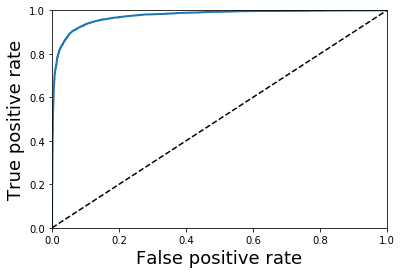

In [26]:
# test model
test_loss, test_predict = sess.run([loss_function, predictions], 
                                     feed_dict={inputs: X_test, 
                                                targets: Y_test, 
                                                keep_prob_conv: 1.0, 
                                                keep_prob_dense: 1.0})

# calculate performance metrics
fpr, tpr, thresholds = roc_curve(Y_test[:,0], test_predict[:,0])
score = auc(fpr, tpr)

print("  test loss:\t\t{:.6f}".format(test_loss))
print("  test AU-ROC:\t\t{:.6f}".format(score))

fig = plt.figure()
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], '--k')
plt.xlabel('False positive rate', fontsize=18)
plt.ylabel('True positive rate', fontsize=18)
plt.xlim([0,1])
plt.ylim([0,1]);

# Let's visualize first convolutional layer filters

In [27]:
# get the convolutional filters
filters = sess.run(W1)

# reshape them so that we can visualize them easier
filters = np.squeeze(filters).transpose([2,1,0])

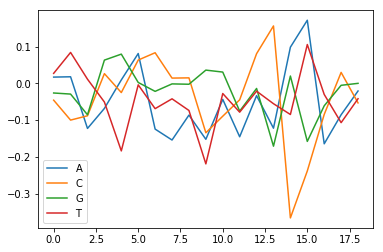

In [12]:
plt.figure()
plt.plot(filters[11].T)
plt.legend(['A', 'C', 'G', 'T'])

Plotting the filters is pretty difficult to interpret.  I've included some plotting functions in impress.py.  Lets use impress to normalize individual filters into a PWM and plot it as a sequence logo.  

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/misc/pilutil.py:413: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts,int):
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/misc/pilutil.py:415: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size),float):


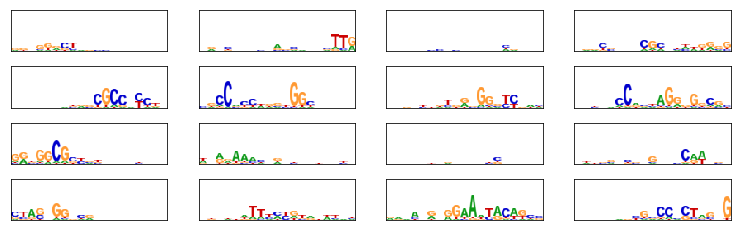

In [13]:
import matplotlib as mpl
import impress

num_filters = filters.shape[0]
grid = mpl.gridspec.GridSpec(4, 4)
grid.update(wspace=0.2, hspace=0.2, left=0.1, right=0.2, bottom=0.1, top=0.2)
fig = plt.figure(figsize=(100,30));
for i in range(num_filters):
    plt.subplot(grid[i]);
    norm_filter = impress.normalize_pwm(filters[i], factor=3)
    logo = impress.seq_logo(norm_filter, height=25, nt_width=10)
    plt.imshow(logo, interpolation='none')
    plt.yticks([])
    plt.xticks([])
    

# Let's generate a saliency map

To calculate a saliency map, we need to calculate the derivative of the output neuron with respect to the inputs.  Luckily, tensorflow makes this easy because it calculates gradients using automatic differentiation.  We can calculate the gradient with the function tf.gradients.  This method constructs partial derivatives of ys w.r.t. x in xs. ys and xs are each a Tensor or a list of tensors. 

tf.gradients(
    ys,
    xs,
    grad_ys=None,
    name='gradients',
    colocate_gradients_with_ops=False,
    gate_gradients=False,
    aggregation_method=None,
    stop_gradients=None
)

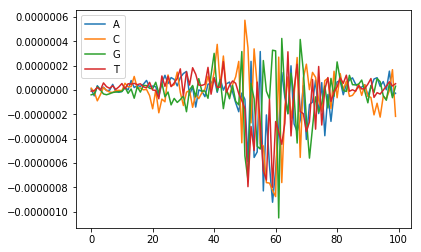

In [16]:
# let's get a sorted list of the highest predicted sequences
max_index = np.argsort(test_predict[:,0])[::-1]

# get a sequence from the list
index = 3
X = np.expand_dims(X_test[max_index[index]], axis=0)

# calculate the gradients to the inputs
grad_to_inputs = tf.gradients(ys=predictions, xs=inputs)

# run the session to calculate the saliency map for a given sequence X
backprop_saliency = sess.run(grad_to_inputs, feed_dict={inputs: X, 
                                                        keep_prob_conv: 1.0, 
                                                        keep_prob_dense: 1.0})

# plot 
plt.plot(np.squeeze(backprop_saliency[0]))
plt.legend(['A','C','G','T'])

I've provided a visualization function to normalize the saliency map to be similar to a PWM and a function to plot a PWM as a sequence logo within the impress module.  

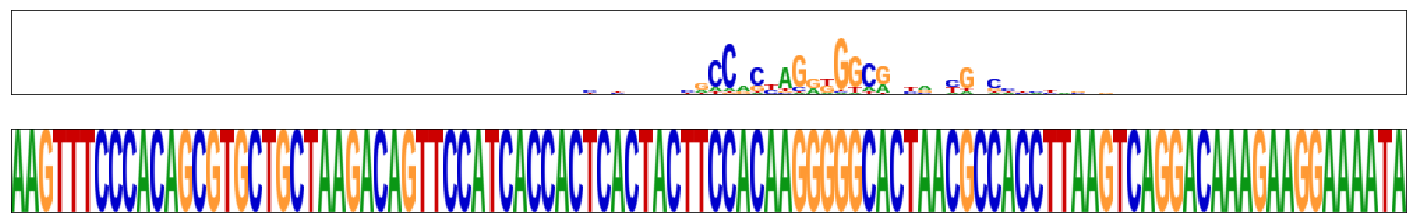

In [17]:
import impress

# filter and normalize saliency map 
norm_saliency = impress.normalize_pwm(np.squeeze(backprop_saliency[0]).T, factor=3)

# generate sequence logo
logo = impress.seq_logo(norm_saliency, height=30, nt_width=10, norm=0)

seq = impress.seq_logo(np.squeeze(X).T, height=30, nt_width=10, norm=0)

# plot sequence logo
plt.figure(figsize=(25,4))
plt.subplot(2,1,1)
plt.imshow(logo)
plt.xticks([]);
plt.yticks([]);
plt.subplot(2,1,2)
plt.imshow(seq)
plt.xticks([]);
plt.yticks([]);